#### A Monte Carlo simulation of Monopoly

There are two kinds of objects - players and boards <br>
The concept and exchange of money is not included in the simulation, and therefore there is no bank.

Simulations are conducted with players running around the boards by rolling dice and drawing cards from the Chance or Community Chest desks. The probability of a player ending up on each tile is approximated by a Monte Carlo simulation.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# For reproducibility
np.random.seed(1)

# No money exchanged

## 1. objects

A player has <br>
1. Status <br>
  a. current position on the board ∈ [0..39] <br>
  b. double counter that counts the number of consecutive doubles rolled ∈ [0..3] -> a player rolling three consecutive doubles is sent to jail  <br>
  c. imprisonment boolean variable ∈ [0,1] that distinguish 'just visiting' and 'in jail' <br>
2. Possession <br>
  a. The jailfree card from Chance deck ∈ [0,1] <br>
  b. The jailfree card from Community Chest deck ∈ [0,1] <br>
3. Record <br>
  a. The total number of occurrences landed on each tile of the board <br>
  b. The total number of occurrences of 'just visiting' and 'in jail' when landed on Jail
 
A player can <br>
1) roll a pair of dice, <br>
2) update and record their new position, <br>
3) update their other status and possessions of jailfree cards, and <br>
4) clean their status and possession when starting a new game

In [2]:
class Player:
    def __init__(self):
        # player status
        self.pos = 0    # current position
        self.double = 0 # double counter, player goes to jail for three consecutive doubles
        self.imprisoned = False # if imprisoned (to distinguish 'just visiting' and 'in jail')
        
        # player possession
        self.jailfree_chance = False
        self.jailfree_community = False
        
        # a player's record
        self.tile_recorder = [0] * 40
        self.jail_recorder = [0] * 2 # distinguish 'just visiting' and 'in jail' 
        
    # Roll dice
    def roll_dice(self):
        # 1. Roll two fair six-sided dice
        dice = [np.random.randint(1,6+1) for _ in range(2)] 
        # 2. record if it was a double, or reset double counter otherwise
        if dice[0] == dice[1]: 
            self.double += 1
        else:
            self.reset_double()
        # 3. return sum of dice values
        return sum(dice) 
    
    # Update and record position
    def update_pos(self, new_pos):
        self.pos = new_pos
        self.tile_recorder[new_pos] += 1
        # Record status at jail (imprisoned or visiting)
        if new_pos == 10:
                if self.imprisoned:
                    self.jail_recorder[1] += 1
                else:
                    self.jail_recorder[0] += 1
                    
    # Reset double counter
    def reset_double(self):
        self.double = 0
    
    # Update the possession of jail free cards
    def update_jailfree(self, get_or_use, chance_or_community):
        if chance_or_community == 'Chance':
            if get_or_use == 'get':
                self.jailfree_chance = True
            else:
                self.jailfree_chance = False
        else:
            if get_or_use == 'get':
                self.jailfree_community = True
            else:
                self.jailfree_community = False
    
    # Update imprisoned status
    def update_imprisoned(self, new_state):
        self.imprisoned = new_state
    
    def new_game(self):
        self.pos = 0
        self.double = 0 
        self.imprisoned = False 
        self.jailfree_chance = False
        self.jailfree_community = False
        # do not clean player's record

A board has <br>
1. Name, land type, land price, house price, rent (for different number of houses) of each tile <br>
2. Decks of Chance and Community Chest that get shuffled once at the beginning of a game, jailfree cards can be removed and put pack <br>

A board can <br>
1) simulate a turn of a player that rolls a dice and everything going to happen afterwards <br>
2) simulate drawing a card from each deck

In [3]:
class Board:
    def __init__(self):
        self.name = ['Go', 'Brown 1', 'Community Chest 1', 'Brown 2', 'Income Tax',
                     'Station 1', 'Sky 1', 'Chance 1', 'Sky 2', 'Sky 3',
                     'Jail', 'Pink 1', 'Utility 1', 'Pink 2', 'Pink 3',
                     'Station 2', 'Orange 1', 'Community Chest 2', 'Orange 2', 'Orange 3',
                     'Free Parking', 'Red 1', 'Chance 2', 'Red 2', 'Red 3',
                     'Station 3', 'Yellow 1', 'Yellow 2', 'Utility 2', 'Yellow 3',
                     'Go To Jail', 'Green 1', 'Green 2', 'Community Chest 3', 'Green 3',
                     'Station 4', 'Chance 3', 'Blue 1', 'Luxury Tax', 'Blue 2']
        self.name_uk = ['Go', 'Old Kent Road', 'Community Chest', 'Whitechapel Road', 'Income Tax',
                        'King\'s Cross Station', 'The Angel Islington', 'Chance', 'Euston Road', 'Pentonville Road',
                        'Jail', 'Pall Mall', 'Electric Company', 'Whitehall', 'Northumberland Avenue',
                        'Marylebone Station', 'Bow Street', 'Community Chest', 'Marlborough Street', 'Vine Street',
                        'Free Parking', 'The Strand', 'Chance', 'Fleet Street', 'Trafalgar Square',
                        'Fenchurch St Station', 'Leicester Square', 'Coventry Street', 'Water Works', 'Piccadilly',
                        'Go To Jail', 'Regent Street', 'Oxford Street', 'Community Chest', 'Bond Street',
                        'Liverpool Street Station', 'Chance', 'Park Lane', 'Luxury Tax', 'Mayfair']
        self.name_us = ['Go', 'Mediterranean Avenue', 'Community Chest', 'Baltic Avenue', 'Income Tax',
                        'Reading Railroad', 'Oriental Avenue', 'Chance', 'Vermont Avenue', 'Connecticut Avenue',
                        'Jail', 'St. Charles Place', 'Electric Company', 'States Avenue', 'Virginia Avenue',
                        'Pennsylvania Railroad', 'St. James Place', 'Community Chest', 'Tennessee Avenue', 'New York Avenue',
                        'Free Parking', 'Kentucky Avenue', 'Chance', 'Indiana Avenue', 'Illinois Avenue',
                        'B. & O. Railroad', 'Atlantic Avenue', 'Ventnor Avenue', 'Water Works', 'Marvin Gardens',
                        'Go To Jail', 'Pacific Avenue', 'North Carolina Avenue', 'Community Chest', 'Pennsylvania Avenue',
                        'Short Line', 'Chance', 'Park Place', 'Luxury Tax', 'Boardwalk']
        
        self.land_type = ['no', 'land', 'no', 'land', 'no', 'station', 'land', 'no', 'land', 'land',
                          'no', 'land', 'utility', 'land', 'land', 'station', 'land', 'no', 'land', 'land',
                          'no', 'land', 'no', 'land', 'land', 'station', 'land', 'land', 'utility', 'land',
                          'no', 'land', 'land', 'no', 'land', 'station', 'no', 'land', 'no', 'land']
        self.land_price = [-1, 60, -1, 60, -1, 200, 100, -1, 100, 120,
                           -1, 140, 150, 140, 160, 200, 180, -1, 180, 200,
                           -1, 220, -1, 220, 240, 200, 260, 260, 150, 280, 
                           -1, 300, 300, -1, 320, 200, -1, 350, -1, 400]
        self.house_price = [-1, 50, -1, 50, -1, -1, 50, -1, 50, 50,
                            -1, 100, -1, 100, 100, -1, 100, -1, 100, 100,
                            -1, 150, -1, 150, 150, -1, 150, 150, -1, 150, 
                            -1, 200, 200, -1, 200, -1, -1, 200, -1, 200]
        self.rent = [-1, (2,10,30,90,160,250), -1, (4,20,60,180,320,450), -1,
                     (25,50,100,200), (6,30,90,270,400,550), -1, (6,30,90,270,400,550), (8,40,100,300,450,600),
                     -1, (10,50,150,450,625,750), (4*7,10*7), (10,50,150,450,625,750), (12,60,180,500,700,900),
                     (25,50,100,200), (14,70,200,550,750,950), -1, (14,70,200,550,750,950), (16,80,220,600,800,1000),
                     -1, (18,90,250,700,875,1050), -1, (18,90,250,700,875,1050), (20,100,300,750,925,1100),
                     (25,50,100,200), (22,110,330,800,975,1150), (22,110,330,800,975,1150), (4*7,10*7), (24,120,360,850,1025,1200),
                     -1, (26,130,390,900,1100,1275), (26,130,390,900,1100,1275), -1, (28,150,450,1000,1200,1400),
                     (25,50,100,200), -1, (35,175,500,1100,1300,1500), -1, (50,200,600,1400,1700,2000)]
        
        self.chance_deck = ['Advance to Go', 'Advance to Red 3', 'Advance to Pink 1', 
                            'Advance to nearest utility', 'Advance to nearest station', 
                            'Bank pays you', 'Get out of Jail Free', 'Go back 3 spaces', 
                            'Go to Jail', 'Make general repairs', 'Pay fine', 
                            'Advance to Station 1', 'Advance to Blue 2', 
                            'Elected chairman', 'Loan matures', 'Won crossword'] # 16 cards
        self.community_deck = ['Advance to Go', 'Bank error', 'Doctors fees', 
                               'Sale of stock', 'Get out of Jail Free', 'Go to Jail', 
                               'Fund matures', 'Tax refund', 'Birthday', 'Insurance matures', 
                               'Hospital fees', 'School fees', 'Receive consultancy fee', 
                               'Street repairs', 'Beauty contest', 'Inherit']    # 16 cards
                               # 'Opera night' does not exist in UK versions
        
        # Only shuffle when init
        np.random.shuffle(self.chance_deck)
        np.random.shuffle(self.community_deck)
        
    # Bound position in range [0..39]
    def bound(self, pos): 
        return pos % 40
        
    # Simulate a turn of a player
    def turn(self, player): 
        roll_again = True

        while roll_again:
            roll_again = False
            
            # 1. Always use jail free cards if in jail
            # Priority: (Jail free from Chance -> Jail free from Community Chest -> Pay)
            if player.imprisoned:
                if player.jailfree_chance:
                    player.update_jailfree('use', 'Chance')
                    self.chance_deck.append('Get out of Jail Free')
                elif player.jailfree_community:
                    player.update_jailfree('use', 'Community')
                    self.community_deck.append('Get out of Jail Free')
                # Never try rolling a double to get out
                player.update_imprisoned(False) 
            # 2. Roll dice
            dice = player.roll_dice() 
            
            # 3. Go to jail if three doubles
            if player.double == 3: 
                player.reset_double()
                player.update_imprisoned(True)
                new_pos = 10
            else:
                # 4. Walk to an interim position
                interim_pos = self.bound(player.pos + dice) 
                # 5a. if Chance
                if interim_pos in [7,22,36]: 
                    new_pos = self.chance(player, interim_pos)
                # 5b. if Community Chest
                elif interim_pos in [2,17,33]: 
                    new_pos = self.community(player, interim_pos)
                # 5c. if stepped on Go to Jail
                elif interim_pos == 30: 
                    player.update_imprisoned(True)
                    new_pos = 10
                # 5d. otherwise
                else: 
                    new_pos = interim_pos
                    
            # 6. update and record position    
            player.update_pos(new_pos)
            
            # 7. roll again only if it is a double and the player is not imprisoned
            #  competitions consider doubles as an extension of a turn
            if player.double > 0 and not player.imprisoned:
                roll_again = True
        
    # simulate drawing a Chance card
    def chance(self, player, interim_pos):
        # 1. Draw the first card on the deck
        pick = self.chance_deck.pop(0)
        
        # 2. Keep the card if it is jail-free, put it at the bottom of the deck otherwise
        if pick == 'Get out of Jail Free':
            player.update_jailfree('get', 'Chance')
        else:
            self.chance_deck.append(pick)
            
        # 3. Move to new position as stated in the card
        if pick == 'Advance to Go':
            return 0
        elif pick == 'Advance to Red 3':
            return 24
        elif pick == 'Advance to Pink 1':
            return 11
        elif pick == 'Advance to nearest utility':
            if interim_pos > 12 and interim_pos <= 28:
                return 28
            else:
                return 12
        elif pick == 'Advance to nearest station':
            if interim_pos > 5 and interim_pos <= 15:
                return 15
            elif interim_pos > 15 and interim_pos <= 25:
                return 25
            elif interim_pos > 25 and interim_pos <= 35:
                return 35
            else:
                return 5
        elif pick == 'Go back 3 spaces':
            return self.bound(interim_pos - 3)
        elif pick == 'Go to Jail':
            player.update_imprisoned(True)
            return 10
        elif pick == 'Advance to Station 1':
            return 5
        elif pick == 'Advance to Blue 2':
            return 39
        else:
            return interim_pos

    # simulate drawing a Community Chest card  
    def community(self, player, interim_pos):
        # 1. Draw the first card on the deck
        pick = self.community_deck.pop(0)
        
        # 2. Keep the card if it is jail-free, put it at the bottom of the deck otherwise
        if pick == 'Get out of Jail Free':
            player.update_jailfree('get', 'Community')
        else:
            self.community_deck.append(pick)
            
        # 3. Move to new position as stated in the card
        if pick == 'Advance to Go':
            return 0
        elif pick == 'Go to Jail':
            player.update_imprisoned(True)
            return 10
        else:
            return interim_pos

## 2. simulation




$\text{Number of players}= N$<br>
$\text{Total number of rounds}= R \sim \mathcal{N} (30,3^2)$<br>
$\text{Number of opponent turns}= T(N) = (N-1)\ R$<br>

In [4]:
# 30 rounds
# sources: https://blog.ed.ted.com/2017/12/01/heres-how-to-win-at-monopoly-according-to-math-experts/
def get_n_round_stat(n_oppo):
    n_round_mean, n_round_std = 30, 3 # std is rather arbitrary
    return n_round_mean, n_round_std

$\text{Probability of rolling a double}= \frac{1}{6} $<br>
$\text{A player is sent to jail for three doubles.}$<br>
$\text{Expected number of landings in all tiles in 100 turns}=100 \Big(1 + \frac{1}{6} + \frac{1}{36}\Big) \approx 119$

In [5]:
opponents = []
n_oppo = 4-1 # a 4-player game has 3 opponents

n_game = 1e6
n_round_mean, n_round_std = get_n_round_stat(n_oppo)

# 1. Create opponents in a list
for _ in range(n_oppo):
    opponents.append(Player())

# 2. Simulate 1,000,000 games
for i in range(round(n_game)): 
    # by creating a new board and cleaning each player's states
    board = Board()
    for player in opponents:
        player.new_game()
        
    # 3. Simulate a random number of rounds per game
    n_round = np.random.normal(n_round_mean, n_round_std)
    for j in range(round(n_round)): 
        # 4. Simulate each turn for each player
        for player in opponents:
            board.turn(player=player)

## 3. analysis
### a. landing probability

In [6]:
# get colours in RGB for visualisation purpose
def get_colour(name):
    if 'Brown' in name:
        return '#8b4513'
    elif 'Sky' in name:
        return '#87ceeb'
    elif 'Pink' in name:
        return '#ca2c92'
    elif 'Orange' in name:
        return '#ffa500'
    elif 'Red' in name:
        return '#ff0000'
    elif 'Yellow' in name:
        return '#ffff00'
    elif 'Green' in name:
        return '#00ff00'
    elif 'Blue' in name:
        return '#0000ff'
    elif 'Station' in name:
        return '#d7baaa' # dark vanilla
    elif 'Utility' in name:
        return '#bfdbae' # light moss green
    elif 'Jail' in name:
        return '#696969' # dim grey
    elif 'Chance' in name or 'Community Chest' in name:
        return '#ffc3c3' # pink
    else:
        return '#f7ffb2'

In [7]:
board = Board()
tile_name, tile_name_uk, tile_name_us = board.name, board.name_uk, board.name_us

# Add tile counts of all players
tile_cnt = list(map(sum, zip(*[x.tile_recorder for x in opponents])))
jail_cnt = list(map(sum, zip(*[x.jail_recorder for x in opponents])))

tile_prob = [ x/sum(tile_cnt)*100 for x in tile_cnt ]
tile_prob[10] = jail_cnt[1]/sum(tile_cnt)*100 # separate 'in jail' and 'just visiting'
tile_colour = [get_colour(name) for name in tile_name]

# stack just visiting bar on top
just_visiting = [0] * 40
just_visiting[10] = jail_cnt[0]/sum(tile_cnt)*100
just_visiting_colour = ['#5356f4'] * 40

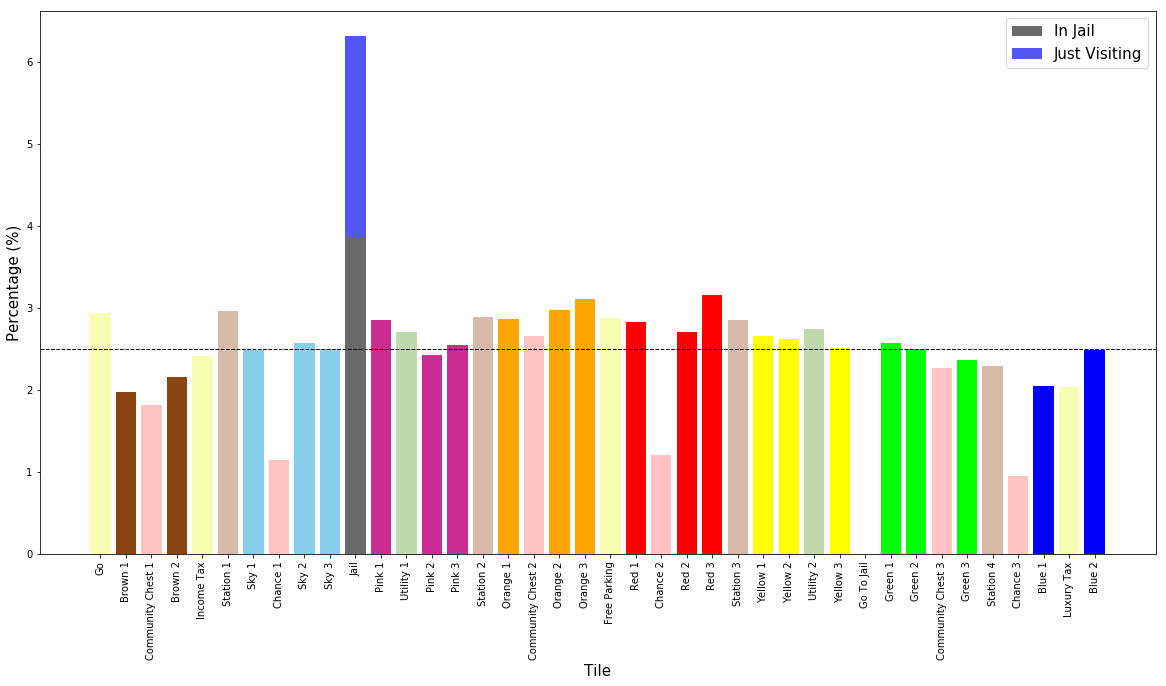

In [8]:
plt.figure(figsize=(20,10))
bottom = plt.bar(tile_name, tile_prob, color=tile_colour)
top = plt.bar(tile_name, just_visiting, bottom=tile_prob, color=just_visiting_colour)

plt.axhline(y=2.5,linewidth=1, color='k', linestyle='--') # mean 100% / 40 tiles = 2.5%/tile

plt.xticks(rotation='vertical')
plt.xlabel('Tile', fontsize=15)
plt.ylabel('Percentage (%)', fontsize=15)
plt.legend((bottom[10], top[10]), ('In Jail', 'Just Visiting'), prop={'size':15})

plt.savefig('landing_prob.png')
plt.show()

In [9]:
df = pd.DataFrame(zip(tile_name, tile_name_uk, tile_name_us, 
                      [ x/sum(tile_cnt)*100 for x in tile_cnt ]),columns=['name', 'name (UK)', 'name (US)', '%'] )

In [10]:
# Most visited tiles
df.sort_values(by=['%'], ascending=False).head(7)

,name,name (UK),name (US),%
10,Jail,Jail,Jail,6.309528
24,Red 3,Trafalgar Square,Illinois Avenue,3.157763
19,Orange 3,Vine Street,New York Avenue,3.109597
18,Orange 2,Marlborough Street,Tennessee Avenue,2.977840
5,Station 1,King's Cross Station,Reading Railroad,2.958115
0,Go,Go,Go,2.934605
15,Station 2,Marylebone Station,Pennsylvania Railroad,2.889000


In [11]:
# Least visited tiles
df.sort_values(by=['%'], ascending=True).head(7)

,name,name (UK),name (US),%
30,Go To Jail,Go To Jail,Go To Jail,0.000000
36,Chance 3,Chance,Chance,0.950768
7,Chance 1,Chance,Chance,1.144576
22,Chance 2,Chance,Chance,1.212095
2,Community Chest 1,Community Chest,Community Chest,1.812370
1,Brown 1,Old Kent Road,Mediterranean Avenue,1.975710
38,Luxury Tax,Luxury Tax,Luxury Tax,2.038847


### b. cost

$\text{Landing probability of a tile} = p(s)$<br>
$\text{Cost of a tile} = c(s,h)$<br>
$\text{Rent of a tile} = r(s,h)$<br>
$\text{where } s, h \text{ are the tile and number of houses respectively}$

In [12]:
board = Board()

# Get costs of a colour set
def get_cost(board, colour, n_house):
    each_house = [ hp for n, hp in zip(board.name, board.house_price) if colour in n ]
    each_land = [ lp for n, lp in zip(board.name, board.land_price) if colour in n ]
    return np.array(each_house) * n_house + np.array(each_land)

# Get rents of a colour set
def get_rent(board, colour, n_house, whole_set=True):
    if n_house > 0:
        assert whole_set == True, 'Incompatible arguments'
    if n_house == 0 and whole_set:
        rent = [ r[n_house]*2 for n, r in zip(board.name, board.rent) if colour in n ]
    else:
        rent = [ r[n_house] for n, r in zip(board.name, board.rent) if colour in n ]
    return np.array(rent)

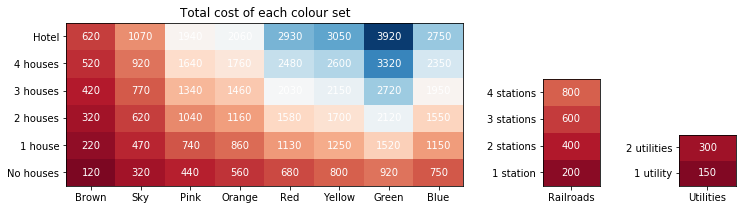

In [13]:
from matplotlib import gridspec

fig, ax = plt.subplots(figsize=(12, 3)) 
gs = gridspec.GridSpec(6,10)
ax = [plt.subplot(gs[:,0:6]), plt.subplot(gs[-4:,7:8]), plt.subplot(gs[-2:,9:10])] 
vmin, vmax = 0, 4000
ax[0].set_title('Total cost of each colour set')

colours = ['Brown', 'Sky', 'Pink', 'Orange', 'Red', 'Yellow', 'Green', 'Blue']
cost_matrix = np.array([[get_cost(board, c, n_house).sum() for c in colours] for n_house in range(0,6)])
matrix_ = [cost_matrix, np.array([200,200*2,200*3,200*4]).reshape(-1,1), np.array([150,150*2]).reshape(-1,1)]
xlabel_ = [colours, ['Railroads'], ['Utilities']]
ylabel_ = [['No houses', '1 house', '2 houses', '3 houses', '4 houses', 'Hotel'], 
           ['1 station', '2 stations', '3 stations', '4 stations'],
           ['1 utility', '2 utilities']]
for i, (matrix, xlabel, ylabel) in enumerate(zip(matrix_, xlabel_, ylabel_)):

    ax[i].pcolormesh(matrix, cmap='RdBu', vmin=vmin, vmax=vmax)
    ax[i].set_xticks(np.arange(0, len(xlabel)) + 0.5)
    ax[i].set_xticklabels(xlabel)
    ax[i].set_yticks(np.arange(0, len(ylabel)) + 0.5)
    ax[i].set_yticklabels(ylabel)

    for j in range(matrix.shape[0]):
        for k in range(matrix.shape[1]):
            text = ax[i].text(k+0.5, j+0.5, int(round(matrix[j,k])),
                           ha='center', va='center', color='w')
            
plt.savefig('cost_matrix.png')
plt.show()

### c. breakeven points

$\text{Expected number of opponent turns to break-even (breakeven point) for a tile is}$
$$b(s,h) = \frac{c(s,h)}{r(s,h) \ p(s)}$$<br>
$\text{Breakeven point for a colour set is }$
$$B(S,h) = \frac{ \sum_{s\in S}c(s,h)}{\sum_{s\in S} r(s,h) \ p(s)}$$<br>
$\text{Incremental breakeven point for a colour set is}$
$$B_{\text{inc}}(S,h) = \frac{ \sum_{s\in S}\big(c(s,h)-c(s,h-1)\big)}{\sum_{s\in S} \big(r(s,h)-r(s,h-1)\big) \ p(s)}$$

In [14]:
def get_breakeven_point(board, colour, n_house, tile_prob):
    
    delta_cost = get_cost(board, colour, n_house)# - get_cost(board, colour, n_house-1)
    delta_rent = get_rent(board, colour, n_house)# - get_rent(board, colour, n_house-1)
    prob = [ p for n, p in zip(board.name, tile_prob) if colour in n ]
    
    return delta_cost.sum() / (delta_rent * prob).sum()

def get_delta_breakeven_point(board, colour, n_house, tile_prob):
    
    delta_cost = get_cost(board, colour, n_house) - get_cost(board, colour, n_house-1)
    delta_rent = get_rent(board, colour, n_house) - get_rent(board, colour, n_house-1)
    prob = [ p for n, p in zip(board.name, tile_prob) if colour in n ]
    
    return delta_cost.sum() / (delta_rent * prob).sum()

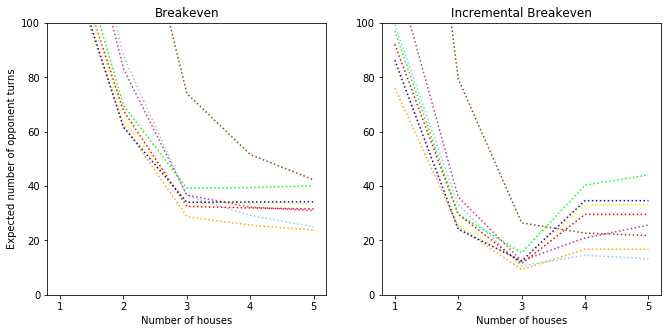

In [15]:
n_houses = range(1,6)
colours = ['Brown', 'Sky', 'Pink', 'Orange', 'Red', 'Yellow', 'Green', 'Blue']
tile_prob = [ x/sum(tile_cnt) for x in tile_cnt ]
fig, ax = plt.subplots(1,2, figsize=(11,5))

for i in range(2):
    ax[i].set_ylim(0,100)
    ax[i].set_xticks(n_houses)
    ax[i].set_xlabel('Number of houses')
    if i == 0:
        ax[i].set_title('Breakeven')
        ax[i].set_ylabel('Expected number of opponent turns')
    else:
        ax[i].set_title('Incremental Breakeven') 
for c in colours:
    breakeven_vec = np.array([get_breakeven_point(board, c, n_house, tile_prob) for n_house in n_houses])
    ax[0].plot(n_houses, breakeven_vec, color=get_colour(c), linestyle='dotted')
    delta_breakeven_vec = np.array([get_delta_breakeven_point(board, c, n_house, tile_prob) for n_house in n_houses])
    ax[1].plot(n_houses, delta_breakeven_vec, color=get_colour(c), linestyle='dotted')

plt.savefig('breakeven.png')
plt.show()

### d. profit

$\text{Profit of a colour set is}$
$$P\big(S,h, T(N)\big) = \text{Total revenue }-\text{ Total cost } = \sum_{s\in S} r(s,h)\ p(s)\ T(N) - \sum_{s\in S}c(s,h) =
\frac{\sum_{s\in S}c(s,h)}{B(S,h)} T(N) - \sum_{s\in S}c(s,h)$$


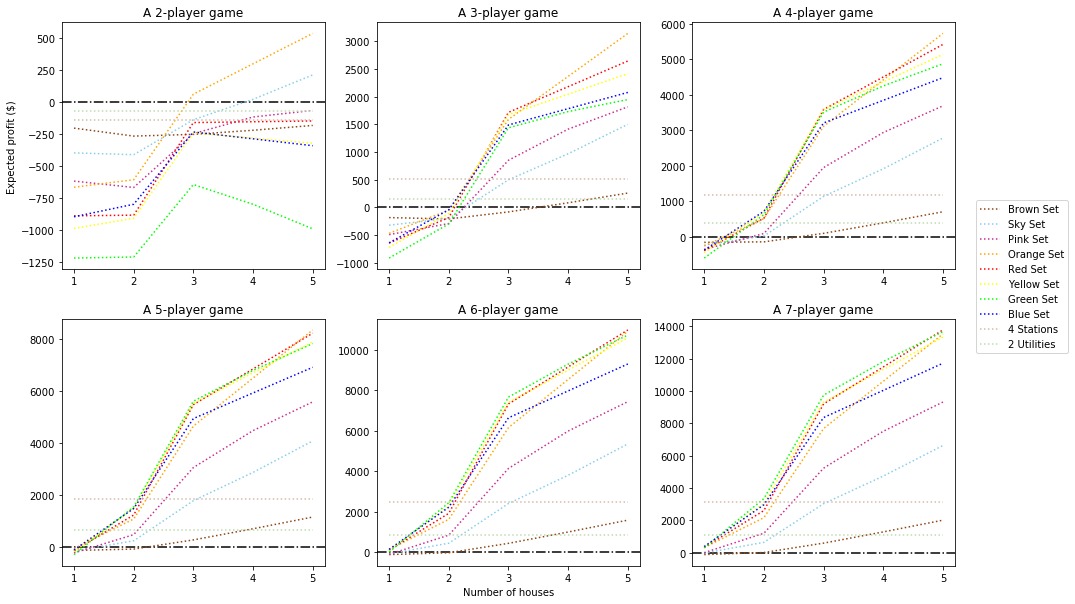

In [16]:
n_houses = range(1,6)
colours = ['Brown', 'Sky', 'Pink', 'Orange', 'Red', 'Yellow', 'Green', 'Blue']
tile_prob = [ x/sum(tile_cnt) for x in tile_cnt ]
station_prob_sum = sum([p for lt, r, p in zip(board.land_type, board.rent, tile_prob) if lt is 'station'])

fig, ax = plt.subplots(2,3, figsize=(16,10))
for i, n_oppo in enumerate(range(1,7)):
    ax[i//3,i%3].axhline(y=0, color='black', linestyle='-.')
    ax[i//3,i%3].set_xticks(n_houses)
    ax[i//3,i%3].set_title(f'A {n_oppo+1}-player game')
    if i == 0:
        ax[i//3,i%3].set_ylabel('Expected profit ($)')
    if i == 4:
        ax[i//3,i%3].set_xlabel('Number of houses')
    for c in colours:
        breakeven_vec = np.array([get_breakeven_point(board, c, n_house, tile_prob) for n_house in n_houses])
        cost_vec = np.array([get_cost(board, c, n_house).sum() for n_house in n_houses])
        profit = cost_vec / breakeven_vec * (get_n_round_stat(n_oppo)[0] * n_oppo) - cost_vec
        ax[i//3,i%3].plot(n_houses, profit, color=get_colour(c), linestyle='dotted', label=f'{c} Set')
        
    # All 4 stations
    profit_all_stations = 200 * station_prob_sum * (get_n_round_stat(n_oppo)[0] * n_oppo) - 200*4
    ax[i//3,i%3].plot(n_houses, [profit_all_stations]*len(n_houses), color=get_colour('Station'), linestyle='dotted', label='4 Stations')

    # All 2 utilities
    profit_all_utilities = 10*7 * station_prob_sum * (get_n_round_stat(n_oppo)[0] * n_oppo) - 150*2
    ax[i//3,i%3].plot(n_houses, [profit_all_utilities]*len(n_houses), color=get_colour('Utility'), linestyle='dotted', label='2 Utilities')
ax[1,2].legend(loc='upper right', bbox_to_anchor=(1.45, 1.5))

plt.savefig('profit.png')
plt.show()

## 4. for fun

In [17]:
# probability of getting imprisoned (not just visiting) in your first turn of a game
n_game = 1e6
n_round = 1
player = Player()
imprisoned_cnt = 0
board = Board()

for i in range(int(n_game)): # simulate a million games
    player.new_game()    
    board.turn(player=player) # simulate a turn for each player
    if player.imprisoned:
        imprisoned_cnt += 1
        
print(f'There is a {imprisoned_cnt/n_game*100:.2f}% chance that you are in Jail after one turn.')

There is a 1.94% chance that you are in Jail after one turn.
